In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from nvidia.nvcomp import as_array, Codec
from pytorch_ggd.GGD import GGD

In [2]:
def measure_codec_performance(
    tensor: torch.Tensor, 
    algorithm: str, 
    warmup_runs: int = 3, 
    timed_runs: int = 5
):
    """
    Measures encode and decode performance for a single algorithm on a given PyTorch tensor.
    Returns:
      - compression_ratio
      - encode_throughput_MBps
      - decode_throughput_MBps
      - avg_encode_time_s
      - avg_decode_time_s
    """

    # 1) Switch the *current device* to match the tensor’s device
    with torch.cuda.device(tensor.device.index):
        codec = Codec(algorithm=algorithm)  # device_id=-1 by default => use current device

        nv_x = as_array(tensor)  # should now be recognized on the same device as codec

        # Warmups
        for _ in range(warmup_runs):
            compressed_nv_x = codec.encode(nv_x)
            _ = codec.decode(compressed_nv_x)
            torch.cuda.synchronize()

        encode_times = []
        decode_times = []

        for _ in range(timed_runs):
            torch.cuda.synchronize()
            t1 = time.perf_counter()
            compressed_nv_x = codec.encode(nv_x)
            torch.cuda.synchronize()
            t2 = time.perf_counter()

            _ = codec.decode(compressed_nv_x)
            torch.cuda.synchronize()
            t3 = time.perf_counter()

            encode_times.append(t2 - t1)
            decode_times.append(t3 - t2)
        
        # Compute metrics
        avg_encode_time = sum(encode_times) / timed_runs
        avg_decode_time = sum(decode_times) / timed_runs

        uncompressed_size = tensor.element_size() * tensor.numel()
        compressed_size = compressed_nv_x.buffer_size
        compression_ratio = compressed_size / uncompressed_size
        
        encode_throughput_MBps = (uncompressed_size / avg_encode_time) / 1_000_000
        decode_throughput_MBps = (uncompressed_size / avg_decode_time) / 1_000_000

    return (compression_ratio, encode_throughput_MBps, decode_throughput_MBps, avg_encode_time, avg_decode_time)

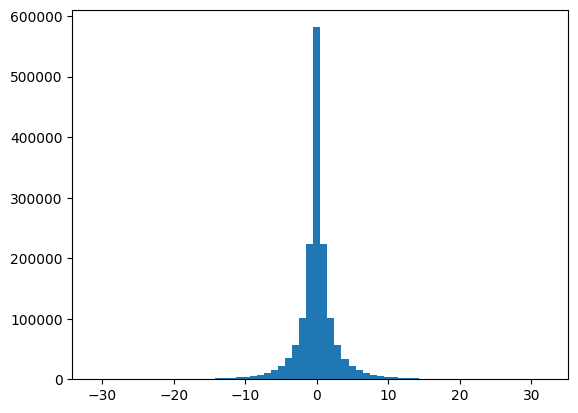

In [3]:
device = "cuda:1"
ggd = GGD(loc=0., scale=0.3, power=0.5)
x = torch.rand(128, 48, 16, 16)
x = x.to(device)
with torch.no_grad():
    x = ggd.icdf(x)
    x = x.clamp(-31.49,31.49).round().to(torch.int8)
plt.hist(x.flatten().cpu().numpy(),bins=64,range=(-31,32));

In [4]:
algorithms = ["LZ4", "Bitcomp", "Snappy", "Zstd", "Deflate", "GDeflate", "ANS", "Cascaded"]

for algo in algorithms:
    comp_ratio, enc_MBps, dec_MBps, enc_time, dec_time = measure_codec_performance(x, algo)
    print(f"\nAlgorithm: {algo}")
    print(f"  - Compression Ratio: {comp_ratio:.2f}")
    print(f"  - Encode Throughput: {enc_MBps:.2f} MB/s")
    print(f"  - Decode Throughput: {dec_MBps:.2f} MB/s")
    print(f"  - Encode Time: {enc_time:.4e} s")
    print(f"  - Decode Time: {dec_time:.4e} s")


Algorithm: LZ4
  - Compression Ratio: 0.87
  - Encode Throughput: 164.79 MB/s
  - Decode Throughput: 500.04 MB/s
  - Encode Time: 9.5445e-03 s
  - Decode Time: 3.1455e-03 s

Algorithm: Bitcomp
  - Compression Ratio: 1.00
  - Encode Throughput: 25175.33 MB/s
  - Decode Throughput: 19069.92 MB/s
  - Encode Time: 6.2476e-05 s
  - Decode Time: 8.2479e-05 s

Algorithm: Snappy
  - Compression Ratio: 0.81
  - Encode Throughput: 136.40 MB/s
  - Decode Throughput: 426.00 MB/s
  - Encode Time: 1.1531e-02 s
  - Decode Time: 3.6922e-03 s

Algorithm: Zstd
  - Compression Ratio: 0.47
  - Encode Throughput: 94.40 MB/s
  - Decode Throughput: 374.75 MB/s
  - Encode Time: 1.6662e-02 s
  - Decode Time: 4.1971e-03 s

Algorithm: Deflate
  - Compression Ratio: 0.48
  - Encode Throughput: 116.80 MB/s
  - Decode Throughput: 243.89 MB/s
  - Encode Time: 1.3467e-02 s
  - Decode Time: 6.4490e-03 s

Algorithm: GDeflate
  - Compression Ratio: 0.48
  - Encode Throughput: 122.50 MB/s
  - Decode Throughput: 575.62 M